In [35]:
import tensorflow as tf
keras=tf.keras
layers=keras.layers

In [36]:
#使用自编码器能够很好解决图像的编码解码问题，但无法随机产生我们想要的数据
#VAE编码器可以解决这个问题
#就是让隐含变量服从一定的分布，限制隐含变量的KL散度（数据分布的一种度量方式）
#KL散度，两个概率分布间差异的非对称性度量
#为了满足这样的数据，我们可以设置Q为预设的分布，让P数据的分布的KL散度最小，从而让P分布逼近Q分布


In [37]:
#但在VAE模型中直接产生这个分布会出现一定的问题
#为了解决这个问题，这里使用重参数化
#编码器并不会直接产生隐含变量，而是输出隐含变量服从的参数，然后使用这些参数产生服从一定分布的隐含变量
#以正态分布为例，重要参数只有两个平均值和标准差，如果让数据按照这个分布的话，那么我们编码器的目的就只是用来生成这两个值
#KLDLoss散度损失函数

In [38]:
#变分自编码器的损失有两部分，第一个是重建损失，第二个损失是KLDloss

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
(train_image,_),_=keras.datasets.mnist.load_data()
train_image.shape

(60000, 28, 28)

In [41]:
#模型的架构 1.生成 均值u和标准差var
#使用这两个参数生成隐含变量
#使用隐含变量来重构图像


In [42]:
train_image=np.reshape(train_image,(-1,784))
train_image=train_image/255
train_image=train_image.astype(np.float32)
train_image.shape

(60000, 784)

In [43]:
data=tf.data.Dataset.from_tensor_slices(train_image)
data=data.shuffle(10000).batch(128)
data

<BatchDataset shapes: (None, 784), types: tf.float32>

0.003921569

In [44]:
class VAE(keras.Model):
    def __init__(self):
        super(VAE,self).__init__()
        self.lin1=layers.Dense(400)
        self.lin2=layers.Dense(20)
        self.lin3=layers.Dense(20)
        self.lin4=layers.Dense(400)
        self.lin5=layers.Dense(784)
    def encode(self,x):
        h1=tf.nn.relu(self.lin1(x))
        return self.lin2(h1),self.lin3(h1) #u,log(var*var)我们认为输出的是方差的对数ln
    def ReParameters(self,u,logvar):
        std=tf.math.exp(0.5*logvar)#真正的标准差
        eps=tf.random.normal(std.shape)#均值为0，方差为1
        return eps*std+u #这样我们就达到了一个正态分布
    def decode(self,z):
        h4=tf.nn.relu(self.lin4(z))
        return tf.nn.sigmoid(self.lin5(h4))#因为原图被我们压缩到0和1之间，所以我们这里使用Sigmoid激活
    def call(self,x):
        u,logvar=self.encode(x)
        z=self.ReParameters(u,logvar)
        return self.decode(z),u,logvar
     


In [45]:
#BCEloss计算从0到1之间概率分布的损失

In [46]:
def loss_function(recon_x, x, u, logvar):
    BCEloss=keras.losses.binary_crossentropy(x,recon_x)
    KLDloss=(-0.5)*tf.reduce_sum((1+2*logvar-tf.pow(u,2)-tf.exp(logvar)))
    return BCEloss+0.0001*KLDloss
#BCEloss控制图像相似性，KLDloss控制正态分布的损失

In [47]:
class VAE_model(tf.keras.Model):
    def __init__(self):
        super(VAE_model, self).__init__()
        self.lin_1 = tf.keras.layers.Dense(400)
        self.lin_2 = tf.keras.layers.Dense(20)
        self.lin_3 = tf.keras.layers.Dense(20)
        self.lin_4 = tf.keras.layers.Dense(400)
        self.lin_5 = tf.keras.layers.Dense(784)
        
    def encode(self, x):
        h1 = tf.nn.relu(self.lin_1(x))
        return self.lin_2(h1), self.lin_3(h1)
    
    def reparameters(self, mu, logvar):
        std = tf.math.exp(0.5*logvar)
        eps = tf.random.normal(std.shape, mean=0.0, stddev=1.0)
        return mu + eps*std
        
    def decode(self, z):
        h4 = tf.nn.relu(self.lin_4(z))
        return tf.sigmoid(self.lin_5(h4))
    
    def call(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameters(mu, logvar)
        return self.decode(z), mu, logvar
model=VAE_model()

In [48]:
optimizer=keras.optimizers.Adam(0.0001)
loss_mean=keras.metrics.Mean('train_loss')


In [49]:
def train_step(model,images):
    with tf.GradientTape() as t:
        pred,u,logvar=model(images)
        loss_step=loss_function(pred, images, u, logvar)
    gradies=t.gradient(loss_step, model.trainable_variables)
    #求解梯度
    optimizer.apply_gradients(zip(gradies, model.trainable_variables)) 
    loss_mean(loss_step)
    return images

In [50]:
train_loss=[]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->
Epoch 1.000, Loss: 0.347


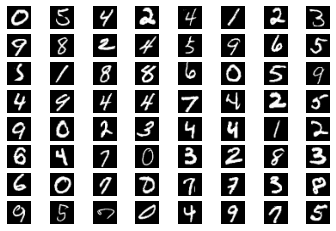

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->
Epoch 2.000, Loss: 0.229


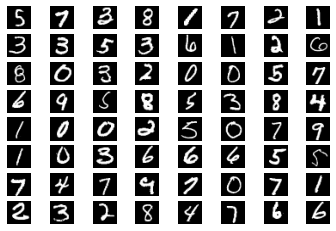

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->
Epoch 3.000, Loss: 0.219


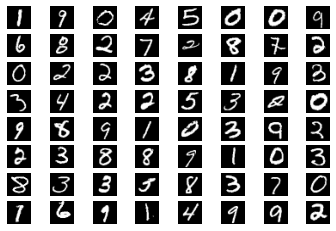

----------------------------------

KeyboardInterrupt: 

In [51]:
Epoch=30
for epoch in range(Epoch):
    loss_mean.reset_states()#重置每个参数的状态
    for images in data:
        imgs=train_step(model,images)
        print('-',end='')#查看训练没批次是否完成
    print('>')
    template = 'Epoch {:.3f}, Loss: {:.3f}'
    print (template.format(epoch+1,
                           loss_mean.result(),
                           ))#输出我们的评价结果
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.imshow(imgs[i].numpy().reshape(28,28),cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
test_mu=np.linspace(-0.9,0.9,2000).reshape(100,20).astype(np.float32)
test_logvar=np.linspace(0,3,2000).reshape(100,20).astype(np.float32)
test_img=model.decode(model.ReParameters(test_mu,test_logvar))
test_img=test_img.numpy().reshape(-1,28,28)


In [53]:
eps = tf.random.normal((32,64,64,64), mean=0.0, stddev=1.0)